# SVM using SMO Algorithm

### Importing Libraries and Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import time

In [2]:
from sklearn.datasets import fetch_openml

In [3]:
mnist = fetch_openml('mnist_784')

In [4]:
data = mnist['data']
target = (mnist['target']).astype(int)
print(data.shape)
print(target.shape)

(70000, 784)
(70000,)


### Data Preprocessing

In [5]:
indices = []
for i, val in enumerate(target):
    if val == 3 or val == 8:
        indices.append(i)

X = data[indices]
y = target[indices]

In [6]:
y_new = np.zeros((len(y)))
for i in range(len(y)):
    if y[i] == 3:
        y_new[i] = 1
    else:
        y_new[i] = -1
y = y_new
print(X.shape)
print(y.shape)

(13966, 784)
(13966,)


In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [8]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(8379, 784)
(2793, 784)
(2794, 784)


In [ ]:
# dat_train = np.column_stack((X_train, y_train))
# dat_test = np.column_stack((X_test, y_test))
# dat_val = np.column_stack((X_val, y_val))

# np.savetxt('data_train.txt',dat_train)
# np.savetxt('data_test.txt',dat_test)
# np.savetxt('data_val.txt',dat_val)

### Define main SVM class

In [9]:
class SVM():
    """
        Simple implementation of a Support Vector Machine using the
        Sequential Minimal Optimization (SMO) algorithm for training.
    """
    def __init__(self, max_iter=10000, kernel_type='linear', C=1.0, gamma = 1,epsilon=0.001):
        self.kernels = {
            'linear' : self.kernel_linear,
            'quadratic' : self.kernel_quadratic,
            'rbf' : self.kernel_rbf
        }
        self.max_iter = max_iter
        self.kernel_type = kernel_type
        self.C = C
        self.gamma = gamma
        self.epsilon = epsilon
    
    def fit(self, X, y):
        
        # Initialization
        n, d = X.shape[0], X.shape[1]
        alpha = np.zeros((n))
        kernel = self.kernels[self.kernel_type]
        count = 0
        
        while True:
            count += 1
            alpha_prev = np.copy(alpha)
            
            for j in range(0, n):
                i = self.get_random_int(0, n-1, j) # Get random int i~=j
                x_i, x_j, y_i, y_j = X[i,:], X[j,:], y[i], y[j]
                if self.kernel_type == 'rbf':
                    k_ij = kernel(x_i, x_i, self.gamma) + kernel(x_j, x_j, self.gamma) - 2 * kernel(x_i, x_j, self.gamma)
                else:
                    k_ij = kernel(x_i, x_i) + kernel(x_j, x_j) - 2 * kernel(x_i, x_j)
                
                if k_ij == 0:
                    continue
                alpha_prime_j, alpha_prime_i = alpha[j], alpha[i]
                L, H = self.compute_L_H(self.C, alpha_prime_j, alpha_prime_i, y_j, y_i)

                # Compute model parameters
                self.w = self.calc_w(alpha, y, X)
                self.b = self.calc_b(X, y, self.w)

                # Compute E_i, E_j
                E_i = self.E(x_i, y_i, self.w, self.b)
                E_j = self.E(x_j, y_j, self.w, self.b)

                # Set new alpha values
                alpha[j] = alpha_prime_j + float(y_j * (E_i - E_j))/k_ij
                alpha[j] = min(max(alpha[j], L), H)       # Clipping
                alpha[i] = alpha_prime_i + y_i*y_j * (alpha_prime_j - alpha[j])

            # Check convergence
            diff = np.linalg.norm(alpha - alpha_prev)
            if diff < self.epsilon:
                break

            if count >= self.max_iter:
                print("Iteration number exceeded the max of %d iterations" % (self.max_iter))
                return
        
        # Compute final model parameters
        self.b = self.calc_b(X, y, self.w)
        if self.kernel_type == 'linear':
            self.w = self.calc_w(alpha, y, X)
        # Get support vectors
        alpha_idx = np.where(alpha > 0)[0]
        support_vectors = X[alpha_idx, :]
        return support_vectors, count
    
    def predict(self, X):
        return self.h(X, self.w, self.b)
    
    def calc_b(self, X, y, w):
        b_tmp = y - np.dot(w.T, X.T)
        return np.mean(b_tmp)
    
    def calc_w(self, alpha, y, X):
        return np.dot(X.T, np.multiply(alpha,y))
    
    # Prediction
    def h(self, X, w, b):
        return np.sign(np.dot(w.T, X.T) + b).astype(int)
    
    # Prediction error
    def E(self, x_k, y_k, w, b):
        return self.h(x_k, w, b) - y_k
    
    def compute_L_H(self, C, alpha_prime_j, alpha_prime_i, y_j, y_i):
        if(y_i != y_j):
            return max(0, alpha_prime_j - alpha_prime_i), min(C, C - alpha_prime_i + alpha_prime_j)
        else:
            return max(0, alpha_prime_i + alpha_prime_j - C), min(C, alpha_prime_i + alpha_prime_j)
    
    def get_random_int(self, a, b, z):
        i = z
        cnt=0
        while cnt<1000:
            i = random.randint(a,b)
            if i != z :
                break
            cnt=cnt+1
        return i
    
    # Define kernels
    def kernel_linear(self, x1, x2):
        return np.dot(x1, x2.T)
    
    def kernel_quadratic(self, x1, x2):
        return (np.dot(x1, x2.T) ** 2)
    
    def kernel_rbf(self, x1, x2, gamma = 1):
        diff = ((np.linalg.norm(x1 - x2)) ** 2) / (2 * gamma * gamma)
        return np.exp(- diff)


### Helper Functions

In [10]:
def metrics(labels, predictions):
    true_pos, true_neg, false_pos, false_neg = 0, 0, 0, 0
    for i in range(len(labels)):
        true_pos += int(labels[i] == 1 and predictions[i] == 1)
        true_neg += int(labels[i] == -1 and predictions[i] == -1)
        false_pos += int(labels[i] == -1 and predictions[i] == 1)
        false_neg += int(labels[i] == 1 and predictions[i] == -1)
    return true_pos, false_pos, true_neg, false_neg

In [11]:
def calculate(C=1.0,kernel='linear',gamma=1,test_type='cv'):
    model = SVM(C=C,kernel_type=kernel,gamma=gamma)
    support_vectors, iterations = model.fit(X_train, y_train)
    sv_count = support_vectors.shape[0]
    
    X = X_val if test_type == 'cv' else X_test
    y = y_val if test_type == 'cv' else y_test
    
    y_pred = model.predict(X)
    TP, FP, TN, FN = metrics(y, y_pred)

    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    Fscore = 2 * precision * recall / (precision + recall)
    accuracy = (TP + TN) / (TP + TN + FP + FN)

    print("Support vector count: %d" % (sv_count))
    print("Converged after %d iterations" % (iterations))
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F-score: ", Fscore)
    print("Accuracy: ", accuracy)
    return y, y_pred

In [12]:
def plot_roc(y,y_pred):
    import sklearn.metrics as metrics
    fpr, tpr, threshold = metrics.roc_curve(y, y_pred)
    roc_auc = metrics.auc(fpr, tpr)
    print('AUC: ', roc_auc)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

### Model Training and Evaluation

#### Kernel = 'linear'

Support vector count: 724
Converged after 1 iterations
Precision:  0.9682875264270613
Recall:  0.9541666666666667
F-score:  0.9611752360965373
Accuracy:  0.9602577873254565
AUC:  0.9604536215816704


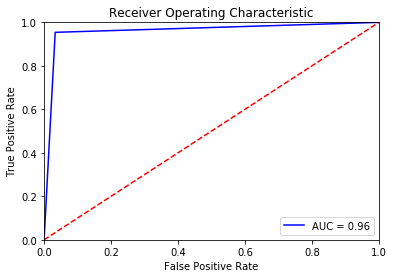

In [13]:
y, y_pred = calculate(kernel='linear',C=1.0,test_type='cv')
plot_roc(y,y_pred)

Support vector count: 751
Converged after 1 iterations
Precision:  0.9681077250177179
Recall:  0.9486111111111111
F-score:  0.9582602595580498
Accuracy:  0.9573934837092731
AUC:  0.9576758438038926


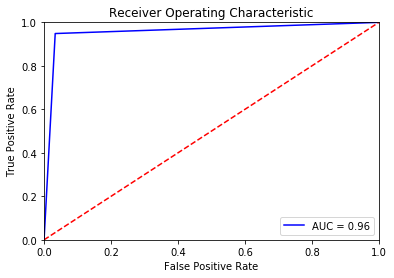

In [14]:
y, y_pred = calculate(kernel='linear',C=10.0,test_type='cv')
plot_roc(y,y_pred)

Support vector count: 764
Converged after 1 iterations
Precision:  0.959915611814346
Recall:  0.9479166666666666
F-score:  0.9538784067085954
Accuracy:  0.9527389903329753
AUC:  0.9528940317812269


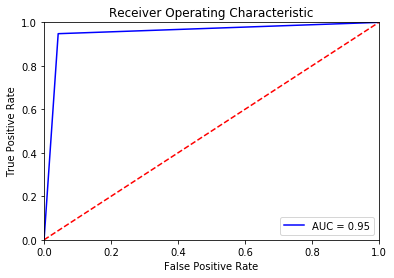

In [18]:
y, y_pred = calculate(kernel='linear',C=100.0,test_type='cv')
plot_roc(y,y_pred)

Support vector count: 697
Converged after 1 iterations
Precision:  0.9701492537313433
Recall:  0.9479166666666666
F-score:  0.9589041095890412
Accuracy:  0.958109559613319
AUC:  0.9584372690317813


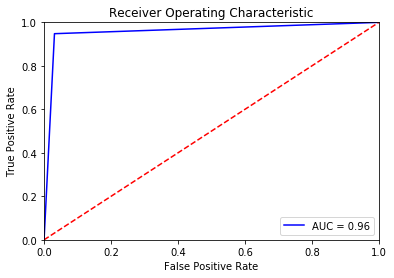

In [19]:
y, y_pred = calculate(kernel='linear',C=1000.0,test_type='cv')
plot_roc(y,y_pred)

#### Kernel = 'quadratic'

Support vector count: 5829
Converged after 1 iterations
Precision:  0.5155746509129968
Recall:  1.0
F-score:  0.6803685329553508
Accuracy:  0.5155746509129968
AUC:  0.5


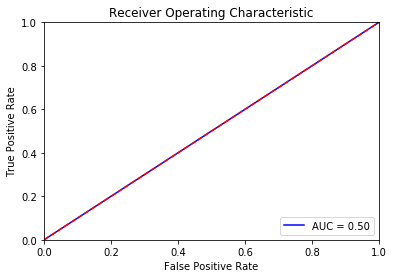

In [15]:
y, y_pred = calculate(kernel='quadratic',C=1.0,test_type='cv')
plot_roc(y,y_pred)

#### Kernel = 'rbf'

Support vector count: 976
Converged after 9 iterations
Precision:  0.9709631728045326
Recall:  0.9520833333333333
F-score:  0.9614305750350631
Accuracy:  0.9606158252774795
AUC:  0.9608901515151516


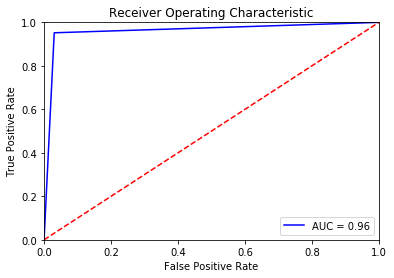

In [16]:
y, y_pred = calculate(kernel='rbf',C=1.0,gamma=1,test_type='cv')
plot_roc(y,y_pred)

Support vector count: 1002
Converged after 7 iterations
Precision:  0.967445152158528
Recall:  0.9493055555555555
F-score:  0.9582895198037155
Accuracy:  0.9573934837092731
AUC:  0.9576535168760779


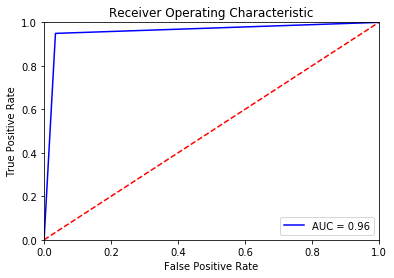

In [17]:
y, y_pred = calculate(kernel='rbf',C=1.0,gamma=25,test_type='cv')
plot_roc(y,y_pred)

Support vector count: 970
Converged after 9 iterations
Precision:  0.9702549575070821
Recall:  0.9513888888888888
F-score:  0.9607293127629734
Accuracy:  0.9598997493734336
AUC:  0.9601733801428924


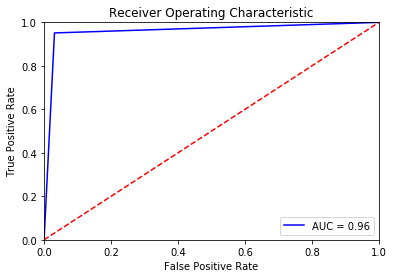

In [20]:
y, y_pred = calculate(kernel='rbf',C=1.0,gamma=100,test_type='cv')
plot_roc(y,y_pred)

Support vector count: 2720
Converged after 19 iterations
Precision:  0.9744136460554371
Recall:  0.9520833333333333
F-score:  0.9631190727081139
Accuracy:  0.9624060150375939
AUC:  0.9627378972653363


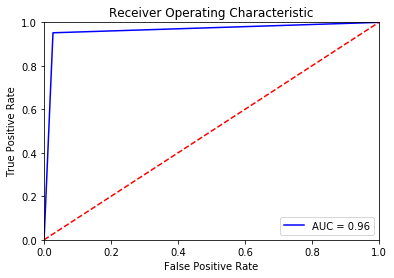

In [21]:
y, y_pred = calculate(kernel='rbf',C=10.0,gamma=25,test_type='cv')
plot_roc(y,y_pred)

Support vector count: 1326
Converged after 9 iterations
Precision:  0.9667374380750177
Recall:  0.9486111111111111
F-score:  0.9575885033298281
Accuracy:  0.9566774078052274
AUC:  0.9569367455038186


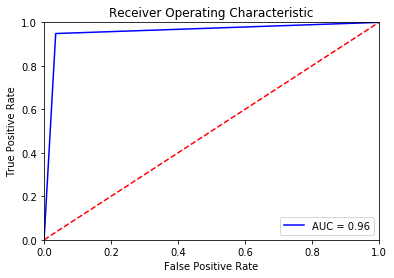

In [22]:
y, y_pred = calculate(kernel='rbf',C=10.0,gamma=100,test_type='cv')
plot_roc(y,y_pred)